In [1]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt


import torch
from torch import nn
from torch.autograd import Variable
from torchsummary import summary
import torch.utils.data as Data
import os
from sklearn.metrics import mean_squared_error
from math import sqrt
from tqdm.notebook import trange

## 資料爬蟲

In [2]:
import yfinance as yf

def crawler(crypto_1, crypto_2, crypto_3, crypto_4): 
    crypto1 = yf.Ticker(str(crypto_1) + "-USD")
    crypto1_data = crypto1.history(start="2018-01-02", end="2021-07-01")

    crypto2 = yf.Ticker(str(crypto_2) + "-USD")
    crypto2_data = crypto2.history(start="2018-01-02", end="2021-07-01")

    crypto3 = yf.Ticker(str(crypto_3) + "-USD")
    crypto3_data = crypto3.history(start="2018-01-02", end="2021-07-01")

    crypto4 = yf.Ticker(str(crypto_4) + "-USD")
    crypto4_data = crypto4.history(start="2018-01-02", end="2021-07-01")

    
    df_for_price = pd.DataFrame({str(crypto_1)+"_Close": crypto1_data["Close"],
                                str(crypto_2)+"_Close": crypto2_data["Close"],
                                str(crypto_3)+"_Close": crypto3_data["Close"],
                                str(crypto_4)+"_Close": crypto4_data["Close"]
                                })
    
    #print(df_for_price)
    return df_for_price
                            

#範例
df_for_price = crawler("ETH", "BNB", "BCH", "BTC")
df_for_price

,ETH_Close,BNB_Close,BCH_Close,BTC_Close
Date,,,,
2018-01-01,772.640991,8.414610,2432.540039,13657.200195
2018-01-02,884.443970,8.837770,2711.000000,14982.099609
2018-01-03,962.719971,9.535880,2608.689941,15201.000000
2018-01-04,980.921997,9.213990,2430.179932,15599.200195
2018-01-05,997.719971,14.917200,2584.479980,17429.500000
...,...,...,...,...
2021-06-26,1829.239258,279.438049,458.776184,32186.277344
2021-06-27,1978.894653,290.567017,476.887299,34649.644531
2021-06-28,2079.657471,289.534119,500.670563,34434.335938


## 資料清洗


In [3]:
def check_missing_data(df):
    # check for any missing data in the df (display in descending order)
    return df.isnull().sum(axis = 1).sort_values(ascending=False)
check_missing_data(df_for_price)

Date
2021-06-30    0
2019-03-04    0
2019-02-25    0
2019-02-26    0
2019-02-27    0
             ..
2020-05-01    0
2020-05-02    0
2020-05-03    0
2020-05-04    0
2018-01-01    0
Length: 1277, dtype: int64

In [4]:
df_for_price.dropna(axis = 0, inplace = True)
df_for_price = df_for_price.reset_index(drop=True)
print('剔除缺失值後資料期間為',len(df_for_price),'天')
df_for_price


剔除缺失值後資料期間為 1277 天


,ETH_Close,BNB_Close,BCH_Close,BTC_Close
0,772.640991,8.414610,2432.540039,13657.200195
1,884.443970,8.837770,2711.000000,14982.099609
2,962.719971,9.535880,2608.689941,15201.000000
3,980.921997,9.213990,2430.179932,15599.200195
4,997.719971,14.917200,2584.479980,17429.500000
...,...,...,...,...
1272,1829.239258,279.438049,458.776184,32186.277344
1273,1978.894653,290.567017,476.887299,34649.644531
1274,2079.657471,289.534119,500.670563,34434.335938
1275,2160.768311,300.211548,522.271362,35867.777344


## 秀出所選幣種剃除缺失值後之資料期間

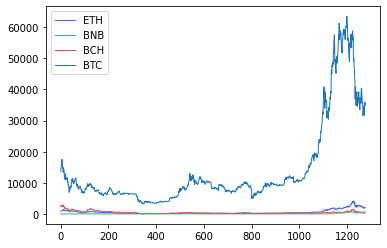

In [5]:
def datashow(df_for_price,crypto_1, crypto_2, crypto_3):
    col = list(df_for_price.columns)
    data_x1= df_for_price.loc[:, [col[0]]]
    data_x2= df_for_price.loc[:, [col[1]]]
    data_x3= df_for_price.loc[:, [col[2]]]
    data_y = df_for_price.loc[:, [col[3]]]
    
    plt.plot(data_x1 , '#4169E1', label=crypto_1, linewidth=1)
    plt.plot(data_x2 , '#3CB371', label=crypto_2, linewidth=1)
    plt.plot(data_x3 , '#CD5C5C', label=crypto_3, linewidth=1)
    plt.plot(data_y  ,  label='BTC' ,linewidth=1)
    plt.legend()
    plt.savefig("C:\\Users\\GOD\\coding\\mysite\\static\\資料期間.jpg") 
    plt.show()
    plt.close()

datashow(df_for_price,"ETH","BNB","BCH")

# 演算法

## LSTM部分

In [6]:
col = list(df_for_price.columns)
data_x_origin = df_for_price.loc[:, [col[0],col[1],col[2]]]
data_y_origin = df_for_price.loc[:, [col[3]]]
data_x = data_x_origin.values
data_y = data_y_origin.values
print(data_x)
print(data_y)

[[ 772.64099121    8.41460991 2432.54003906]
 [ 884.44396973    8.83777046 2711.        ]
 [ 962.7199707     9.53588009 2608.68994141]
 ...
 [2079.6574707   289.53411865  500.67056274]
 [2160.76831055  300.21154785  522.2713623 ]
 [2274.54760742  303.29586792  526.2958374 ]]
[[13657.20019531]
 [14982.09960938]
 [15201.        ]
 ...
 [34434.3359375 ]
 [35867.77734375]
 [35040.8359375 ]]


Epoch: 100, Loss: 0.04072
Epoch: 200, Loss: 0.03801
Epoch: 300, Loss: 0.03386
Epoch: 400, Loss: 0.02884
Epoch: 500, Loss: 0.02554
Epoch: 600, Loss: 0.02920
Epoch: 700, Loss: 0.02327
Epoch: 800, Loss: 0.02091
Epoch: 900, Loss: 0.01913
Epoch: 1000, Loss: 0.01793
Epoch: 1100, Loss: 0.01808
Epoch: 1200, Loss: 0.01648
Epoch: 1300, Loss: 0.01571
Epoch: 1400, Loss: 0.01588
Epoch: 1500, Loss: 0.01584
Epoch: 1600, Loss: 0.01349
Epoch: 1700, Loss: 0.01235
Epoch: 1800, Loss: 0.01220
Epoch: 1900, Loss: 0.01214
Epoch: 2000, Loss: 0.01248


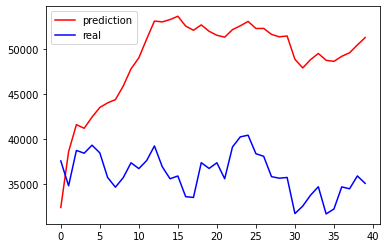

13792.167304952256

In [7]:

day=40
BATCH_SIZE =1024
NUM_LAYER =2
HIDDEN_SIZE =200
LEARNING_RATE =0.7
WEIGHT_DECAY =0
EPOCH =2000


data_x = ((data_x/data_x[0]) - 1 )    
data_x = np.array(data_x)
#data_x = np.array(data_x_normed)
data_y = ((data_y/data_y[0]) - 1 )   #對y值進行 first value-based normalization
data_y = np.array(data_y)
#print(data_y)
#plt.plot(data_y)
total_period = len(data_x)

    
day = len(data_y) - day
train_size = int(day)                #訓練樣本數目
test_size = len(data_x) - train_size  #測試樣本數目
#print(test_size)

train_x = data_x[:train_size]
train_y = data_y[:train_size]
test_x = data_x[train_size:]
test_y = data_y[train_size:]

    # 偷看一下運行結果... 
    # print(train_x)
    # print("------------")
    # train_x = train_x.reshape(-1, 1)
    # print(train_x)
    # print("------------")

train_x = train_x.reshape(-1, 1, 3)    #總共有三個維度：我不知道第一個維度有多少(i.e. 我不知道有多少日的價格資料，我要讓程式自己去跑這個數字)，但我知道在第一個維度下有1串資料，每一串資料有10個特徵

'''
分析程式背後含義 (若不懂則建議一行一行執行)
print(train_x)
print(train_x[0])
print(train_x[0][0])
print(len(train_x))                    # 共有3000天的資料
print(len(train_x[0]))                 # 每天共有一串資料
print(len(train_x[0][0]))              # 每串資料共有十個特徵
'''

train_y = train_y.reshape(-1, 1)        #把它變成3600列、然後只有1行的概念
train_x = torch.from_numpy(train_x)     #把array轉成tensor格式 https://pytorch.org/docs/stable/generated/torch.from_numpy.html
train_y = torch.from_numpy(train_y)

test_x = test_x.reshape(-1, 1, 3)
test_y = test_y.reshape(-1, 1)
test_x = torch.from_numpy(test_x)     
test_y = torch.from_numpy(test_y)

data_train = Data.TensorDataset(train_x, train_y)
data_test = Data.TensorDataset(test_x, test_y)

    
data_loader_train=torch.utils.data.DataLoader(dataset=data_train,batch_size=BATCH_SIZE,shuffle=True)

    
class NET(nn.Module):
    def __init__(self,input_size=3,hidden_size = HIDDEN_SIZE,output_size = 1,num_layer = NUM_LAYER): # hidden_size：隱藏層神經元個數是我們自己設定的
            super(NET,self).__init__()                                              #允許使用者在子類中調用超類的方法
            self.rnn=nn.LSTM(input_size,hidden_size,num_layer)                      #定義 LSTM
            self.out=nn.Linear(hidden_size,output_size)                             #设置网络中的全连接层的，需要注意的是全连接层的输入与输出都是二维张量   https://blog.csdn.net/qq_42079689/article/details/102873766
    def forward(self,x):
            out,_=self.rnn(x)
            out=self.out(out[:,-1,:])
            return out

net = NET()      # 啟動 Net
    
OPTIMIZER = "Adadelta"
    

#optimizer = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=WEIGHT_DECAY)
optimizer = torch.optim.Adadelta(net.parameters(), lr=LEARNING_RATE, rho=0.9, eps=1e-06, weight_decay=WEIGHT_DECAY)  # 補1：先构造一个优化器对象Optimizer，用来保存当前的状态，并能够根据计算得到的梯度来更新参数。
loss_func = torch.nn.MSELoss()        #均方損失函數                                                       # 補2：優化器 https://blog.csdn.net/Ibelievesunshine/article/details/99624645
if torch.cuda.is_available():
    net.cuda()                        # 将所有的模型参数移动到 GPU 上， i.e. 将数据的形式变成 GPU 能读的形式，然后将 CNN 也变成 GPU 能读的形式之概念

net.train(mode=True)


    

loss_list = []
for epoch in range(EPOCH):              # 對網絡訓練 7000 次
    train_x,train_y = train_x.float().cuda(),train_y.float().cuda()    # 将数据(和网络)都推到 GPU，接上.cuda()
    var_x=Variable(train_x)            # 用Variable包一下，才可在GPU上做運算
    var_y=Variable(train_y)
    out = net(var_x) 
    loss = loss_func(out, var_y)       # 計算損失函數
    loss_list.append(loss.item())
        
    optimizer.zero_grad()              # 意思是把梯度置零，也就是把loss关于weight的导数变成0. https://blog.csdn.net/scut_salmon/article/details/82414730
    loss.backward()                    # i.e. 反向传播求梯度
    optimizer.step()                   # 更新所有參數
    if (epoch + 1) % 100 == 0:         
        print('Epoch: {}, Loss: {:.5f}'.format(epoch + 1, loss.data))

            
            

    
net.eval()

test_x,test_y = test_x.float().cuda(),test_y.float().cuda()
var_x=Variable(test_x)
var_y=Variable(test_y)
pred_test = net(var_x)
pred_test = pred_test.view(-1).data                          #view()函数作用是将一个多行的Tensor,拼接成一行。 https://blog.csdn.net/program_developer/article/details/82112372
#pred_test=torch.max(pred_test,1)[1].data.numpy().squeeze()




pred__test = pred_test.cpu()


data_y = data_y_origin.values


#數據轉換
prediction_value = (pred__test + 1) * data_y[0]
test_y = (test_y.cpu() + 1) * data_y[0]
    

plt.plot(prediction_value.cpu().numpy() , 'r', label='prediction')
plt.plot(test_y.detach().cpu().numpy() , 'b', label='real')
plt.legend(loc='best')
plt.savefig("C:\\Users\\GOD\\coding\\mysite\\static\\lstm_forecast.jpg") 
plt.show()
plt.close()

#calculate RMSE
Test_error = sqrt(mean_squared_error(prediction_value.cpu(), test_y.cpu()))
    
Test_error

## C-RNN部分

  0%|          | 0/100 [00:00<?, ?it/s]

Finish 100 epoch,Loss:0.042992,Acc:0.827809


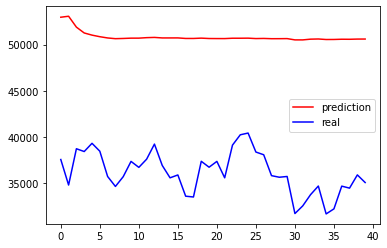

14848.344589789398

In [8]:




col = list(df_for_price.columns)
#col[0]
df01 = df_for_price.loc[:, [col[0], col[1], col[2]]]
df02 = df_for_price.loc[:, [col[1], col[2], col[0]]]
df03 = df_for_price.loc[:, [col[2], col[0], col[1]]]
df04 = df_for_price.loc[:, [col[3]]]
    


day =40    
BATCH_SIZE =1024
NUM_LAYER =2
HIDDEN_SIZE =100
LEARNING_RATE =0.7
WEIGHT_DECAY =1e-8
EPOCH =100
n1 = 10
n2 = 20
n3 = 40


    
    
data_x = np.stack((df01,df02,df03),1)    
total_period = len(data_x)
#    print(total_period)

data_x = data_x.astype('float')
data_y = df04.astype('float')
    
data_x = np.array(data_x)
data_y = np.array(data_y)
data_x = ((data_x/data_x[0]) - 1 )
data_y = ((data_y/data_y[0]) - 1 )   #對y值進行 first value-based normalization
    
day = len(data_y) - day
train_size = int(day)                 #1043是20天；1023是40天；988是75天
test_size = len(data_x) - train_size
#    print(test_size)

train_x = data_x[:train_size]
train_y = data_y[:train_size]
test_x = data_x[train_size:]
test_y = data_y[train_size:]
    
    
#############################################################################################
train_x = torch.from_numpy(train_x)
train_y = torch.from_numpy(train_y)
test_x = torch.from_numpy(test_x)
test_y = torch.from_numpy(test_y)

#轉換維度
train_x = train_x.permute(0,2,1)     
test_x = test_x.permute(0,2,1)

train_x = train_x.float()
train_y = train_y.float()
test_x = test_x.float()
test_y = test_y.float()

data_train = Data.TensorDataset(train_x, train_y)
data_test = Data.TensorDataset(test_x, test_y)


data_loader_train=torch.utils.data.DataLoader(dataset=data_train,batch_size=BATCH_SIZE,shuffle=True)

    
OPTIMIZER = "Adadelta"        #此行只是為了打印，並不影響模型，所以模型處要重新修改優化器
    

class LSTM(nn.Module):
    def __init__(self,nIn,nhidden,nOut,num_layer=2):
        super(LSTM,self).__init__()
        self.lstm=nn.LSTM(nIn,nhidden,num_layer)
                         #Sequence batch channels (W,b,c)
        self.out=nn.Linear(nhidden,nOut)
    def forward(self, input):
        output,_=self.lstm(input)
        output=self.out(output[:,:,:])
        return output
    
    
    
class CRNN(nn.Module):
    def __init__(self,imgC,nclass,nhidden):                                     #論文中卷積 5 層，後面跟著 5 個 ReLU 函數
        super(CRNN,self).__init__()
        cnn = nn.Sequential()
        cnn.add_module('conv{}'.format(0), nn.Conv1d(imgC, n1, 1))              # 參數1：輸入的通道數、參數2：輸出的通道數（即卷積核數量，i.e. 有多少卷積核，就有多少通道）、參數3：捲積核尺寸 
        cnn.add_module('relu{}'.format(0), nn.ReLU(True))
        cnn.add_module('pooling{}'.format(0),nn.MaxPool1d(2))                   #在這裡有 1 層Polling

        cnn.add_module('conv{}'.format(1), nn.Conv1d(n1, n2, 1))                # 輸入的通道數即為上層的卷積核數量
        cnn.add_module('relu{}'.format(1), nn.ReLU(True))
    #   cnn.add_module('pooling{}'.format(1),nn.MaxPool1d(2))

        cnn.add_module('conv{}'.format(2), nn.Conv1d(n2, n3, 1))
    #   cnn.add_module('drop{}'.format(2), nn.Dropout(0.5))                    # 一層 Dropout
        cnn.add_module('relu{}'.format(2), nn.ReLU(True))

    #   cnn.add_module('conv{}'.format(3), nn.Conv1d(10, 10, 1))
    #   cnn.add_module('drop{}'.format(3), nn.Dropout(0.2))
    #   cnn.add_module('relu{}'.format(3), nn.ReLU(True))

    #   cnn.add_module('conv{}'.format(4), nn.Conv1d(10, 10, 1))
    #   cnn.add_module('drop{}'.format(4), nn.Dropout(0.2))
    #   cnn.add_module('relu{}'.format(4), nn.ReLU(True))

    #   cnn.add_module('conv{}'.format(5), nn.Conv1d(320, 640, 1))
    #   cnn.add_module('relu{}'.format(5), nn.ReLU(True))
    #   cnn.add_module('pooling{}'.format(4),nn.MaxPool1d(2))

    #   cnn.add_module('conv{}'.format(6), nn.Conv1d(640, 1280, 1))
    #   cnn.add_module('relu{}'.format(6), nn.ReLU(True))

        self.cnn=cnn

        self.rnn=nn.Sequential(
            LSTM(n3,nhidden,nclass,num_layer = NUM_LAYER)                         #第一個參數接CNN輸出的最後一個參數   / num
        )


    def forward(self,input):
        conv = self.cnn(input)
        #print('conv.size():',conv.size())
        b,c,w=conv.size()
        #conv=conv.squeeze(1)#b ,w
        #conv=conv.reshape[-1,1,c]
        conv=conv.permute(0,2,1) #b,w,c
        rnn_out=self.rnn(conv)                    #即為 def__init__()裡面最後一行，該行計算出來的即為經過卷積以及循環後所得出來的最終out
        #print('rnn_out.size():',rnn_out.size())
        #out=F.log_softmax(rnn_out,dim=2)
        #print('out.size():',out.size())
        return rnn_out


net = CRNN(3, 1, HIDDEN_SIZE)                         # def __init__(self,imgC,nclass,nhidden):  #圖片輸入變數/經過CNN與LSTM後，最終輸出的個數/LSTM每層神經元個數
if torch.cuda.is_available():
    net.cuda()               #将所有的模型参数移动到GPU上
optimizer = torch.optim.Adadelta(net.parameters(), lr=LEARNING_RATE, rho=0.9, eps=1e-06, weight_decay=WEIGHT_DECAY)
loss_fn = torch.nn.MSELoss()

#準備訓練
net.train(mode=True)


for epoch in trange(EPOCH):
    running_loss = 0.0
    running_acc = 0.0
    #训练
    for i,data in enumerate(data_loader_train,1):
        train_x,train_y = data
        #判断是否可以使用GPU，若可以则将数据转化为GPU可以处理的格式。
        if torch.cuda.is_available():
            train_x = Variable(train_x).cuda()
            train_y = Variable(train_y).cuda()
        else:
            train_x = Variable(train_x)
            train_y = Variable(train_y)
        out = net(train_x)
        out = out.squeeze(1)                             # squeeze是用來把維度去掉，在這裡指定把out張量的第二個維度去掉。  https://blog.csdn.net/zenghaitao0128/article/details/78512715
        loss = loss_fn(out,train_y)                      # https://www.jb51.net/article/194848.htm
    #        loss_list.append(loss.item())  #畫損失圖用，沒必要的話就註解掉     

        running_loss += loss.item() * train_y.size(0)
        _, pred = torch.max(out,1)
        num_correct = (pred == train_y.data).sum()
        accuracy = (pred == train_y.data).float().mean()
        running_acc += num_correct.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if (epoch + 1) % 100 == 0:
        print('Finish {} epoch,Loss:{:.6f},Acc:{:.6f}'.format(
            epoch+1,running_loss/(len(data_train)),running_acc/len(data_train)
        ))

net.eval()

#預測值
test_x,test_y = test_x.float().cuda(),test_y.float().cuda()
var_x=Variable(test_x)
var_y=Variable(test_y)
pred_test = net(var_x)
pred_test = pred_test.squeeze(1)
pred_test = pred_test.view(-1).data
pred__test = pred_test.cpu()

#df04 = pd.read_excel(r"C:/Users/liu/Desktop/專題/資料/CNN/價格資料_CNN用_5e(剔除400筆後的不含日期之BTC收盤價)_0630.xlsx")
#df04 = df04[:1064]
data_y = df04.values

prediction_value = (pred__test + 1) * data_y[0]

test_y = (test_y.cpu() + 1) * data_y[0]

plt.plot(prediction_value.cpu().numpy() , 'r', label='prediction')
plt.plot(test_y.detach().cpu().numpy() , 'b', label='real')
plt.legend(loc='best')
plt.savefig("C:\\Users\\GOD\\coding\\mysite\\static\\crnn_forecast.jpg")
plt.show()
plt.close()
Test_error = sqrt(mean_squared_error(prediction_value.cpu(), test_y.cpu()))

Test_error
    
    
    
